In [1]:
import datacleaning
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial import distance
import networkx as nx
import itertools
import matplotlib
import numpy as np
import scipy
# https://realpython.com/nltk-nlp-python/


In [2]:
data = datacleaning.clean_recipedata("recipes_raw_nosource_ar.json", n=5000)
print(np.shape(data))

data
# data.to_csv("data_small.csv")



(5000, 7)


,title,ingredients,instructions,picture_link,clean_ingredients,clean_instructions,clean_instructions_masked
5eA5nRW8VgbOry0hsA.SVnrGkt2AdzO,Southern-Style Chocolate Pound Cake,1 cup butter ADVERTISEMENT 1/2 cup shortening ...,Preheat oven to 350 degrees F (175 degrees C)....,v.IiJhm4GZSZAGtMDWpTfAe6vspLCiu,butter shortening white sugar eggs vanilla ext...,preheat oven degrees degrees grease flour loaf...,preheat oven degrees degrees grease loaf pans ...
DIzfv.NycIqtwo58y7fteog1dKRw12O,Pumpkin Pie I,1 egg ADVERTISEMENT 1 tablespoon all-purpose f...,Preheat oven to 450 degrees F (230 degrees C)....,EbVR3lftwDSDeE1MRSGdi1evygKF/D6,egg allpurpose flour white sugar salt pumpkin ...,preheat oven degrees degrees add sugar gradual...,preheat oven degrees degrees add gradually bea...
TFxp0RPK/1PxAnjYiZUS0KztkgYb3iW,Cinnamon Oatmeal Zucchini Cookies,"1 1/2 cups butter, softened ADVERTISEMENT 1 1/...",Preheat oven to 350 degrees F (175 degrees C)....,jG7CnWbsc8cYsoHbreIorq8Uvyzzk/6,butter softened white sugar eggs vanilla extra...,preheat oven degrees degrees grease baking she...,preheat oven degrees degrees grease sheets bea...
3yH5Jc6HLmEnJw5ggLqI11oeBiSpwBy,Plum-Oat Drop Biscuits,2 tablespoons white sugar ADVERTISEMENT 1/2 te...,Preheat oven to 450 degrees F (230 degrees C)....,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,white sugar ground cinnamon allpurpose flour r...,preheat oven degrees degrees grease baking she...,preheat oven degrees degrees grease sheet comb...
8lZak.EVdLP9/dukyN72DYHyjseFwV2,Ghirardelli Milk Chocolate Chip Cookies,2 1/4 cups all-purpose flour ADVERTISEMENT 1 t...,Preheat the oven to 375 degrees F. Stir togeth...,50UyVqBQayirbQ47M.8oJvkETheUGFW,allpurpose flour baking soda salt unsalted but...,preheat oven degrees stir together flour bakin...,preheat oven degrees stir together set aside b...
...,...,...,...,...,...,...,...
z5ZKH66nGOR2cgkzDl5vGj4DPX/J95O,Sun-Dried Tomato With Fresh Basil Spread,1/2 cup oil-packed sun-dried tomatoes ADVERTIS...,Place sun-dried tomatoes in the work bowl of a...,IV7I3CRDxEMTrdHzOCE3YHxewYs0JQW,oilpacked sundried tomatoes basil leaves ounce...,place sundried tomatoes work bowl food process...,place work bowl food processor pulse coarsely ...
g1mQzPtIoBSaOaaHSkMj7cObWt0r5.K,Banana Split Martini,ice as needed ADVERTISEMENT 2 fluid ounces whi...,Fill a cocktail shaker with ice; add white cho...,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,ice needed fluid ounces white chocolate liqueu...,fill cocktail shaker ice add white chocolate l...,fill cocktail shaker add creme de cover shake ...
dsDOddsQtDp7xomWY2mQwcoTyLeUfYa,Citrus Glazed Banana Squash,"1 1/2 pounds banana squash, peeled and cubed A...",Melt butter in a large skillet over medium hea...,SkAAXlzdZZcQ6UmAO72KI82FiqpAG9y,banana squash peeled cubed butter water needed...,melt butter large skillet medium heat add squa...,melt large skillet medium heat add cubes cover...
CdxL1ghjiOgZTF8mPLi/JdaUW74ARmq,Classic Spanish Sangria,1 lemon ADVERTISEMENT 1 lime ADVERTISEMENT 1 o...,"Have the fruit, rum, wine, and orange juice we...",xCSyOeooKYofbXHuZpV5h7prJrWUDhK,lemon lime orange rum white sugar bottle dry r...,fruit rum wine orange juice well chilled slice...,fruit well chilled slice thin rounds place lar...


In [3]:
data.to_csv("data_small.csv")

In [4]:
data["ingredient_words"] = data.clean_ingredients.apply(word_tokenize)
data["instruction_words"] = data.clean_instructions_masked.apply(word_tokenize)

In [ ]:
# ingredient_units = {'inch', 'ml', 'milliliter','milliliters','liters','teaspoons', 'l','liter','teaspoon','t','tsp','tablespoon','tablespoons','tbl','tbs','tbsp','ounce','oz','fl','cup','cups','c','pint','pints','pt','p','quart','quarts','qt','gal','gals','gallon','gallons','g','mg','milligram','milligrams','gram','grams','pound','pounds','lb','lbs','c','f'}

In [5]:
# stop_words = set(stopwords.words("english"))
# stop_words = stop_words.union(ingredient_units)

# def filter_stop_words(words):
#     output = list()
#     for word in words:
#         if word.casefold() not in stop_words:
#             output.append(word)
#     return(output)

# data["instruction_words"] = data["instruction_words"].apply(filter_stop_words)
# data["ingredient_words"] = data["ingredient_words"].apply(filter_stop_words)
data['index'] = data.index
data.to_csv("data_small.csv")


In [6]:
data["ingredient_words"]

5eA5nRW8VgbOry0hsA.SVnrGkt2AdzO    [butter, shortening, white, sugar, eggs, vanil...
DIzfv.NycIqtwo58y7fteog1dKRw12O    [egg, allpurpose, flour, white, sugar, salt, p...
TFxp0RPK/1PxAnjYiZUS0KztkgYb3iW    [butter, softened, white, sugar, eggs, vanilla...
3yH5Jc6HLmEnJw5ggLqI11oeBiSpwBy    [white, sugar, ground, cinnamon, allpurpose, f...
8lZak.EVdLP9/dukyN72DYHyjseFwV2    [allpurpose, flour, baking, soda, salt, unsalt...
                                                         ...                        
z5ZKH66nGOR2cgkzDl5vGj4DPX/J95O    [oilpacked, sundried, tomatoes, basil, leaves,...
g1mQzPtIoBSaOaaHSkMj7cObWt0r5.K    [ice, needed, fluid, ounces, white, chocolate,...
dsDOddsQtDp7xomWY2mQwcoTyLeUfYa    [banana, squash, peeled, cubed, butter, water,...
CdxL1ghjiOgZTF8mPLi/JdaUW74ARmq    [lemon, lime, orange, rum, white, sugar, bottl...
zDZUSIRODtz86LgwPyFH3AoMoPO8p.2    [cooked, seasoned, frozen, beef, strips, thawe...
Name: ingredient_words, Length: 5000, dtype: object

In [7]:
all_instruction_words = list(itertools.chain.from_iterable(data["instruction_words"]))
all_ingredient_words = list(itertools.chain.from_iterable(data["ingredient_words"]))

In [8]:
len(FreqDist(all_ingredient_words).items())

2710

In [9]:
# Instructions
common_instruction_words = []

for item in FreqDist(all_instruction_words).items():
    if (item[1]) > (len(data)*.01): # remove words that appear less than once per hundred recipes
        common_instruction_words.append(item)


common_instruction_words = sorted(common_instruction_words, key=lambda x: x[1], reverse=True)

common_instruction_words_dict = {}
for i in range(len(common_instruction_words)):
    common_instruction_words_dict[common_instruction_words[i][0]] = i



# Ingredients
common_ingredient_words = []
for item in FreqDist(all_ingredient_words).items():
    if (item[1]) > (len(data)*.01): # remove words that appear less than once per hundred recipes
        common_ingredient_words.append(item)

common_ingredient_words = sorted(common_ingredient_words, key=lambda x: x[1], reverse=True)

common_ingredient_words_dict = {}
for i in range(len(common_ingredient_words)):
    common_ingredient_words_dict[common_ingredient_words[i][0]] = i

In [41]:
len(data)*.01

50.0

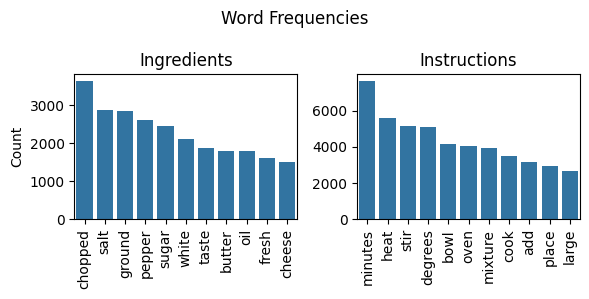

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
ingred = ((pd.DataFrame({a:[b] for a, b in common_ingredient_words})).T.reset_index())
ingred = ingred[ingred[0] > 1500]

inst = ((pd.DataFrame({a:[b] for a, b in common_instruction_words})).T.reset_index())
inst = inst[inst[0] > 2500]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

a = sns.barplot(y=ingred[0], x=ingred['index'], ax = axes[0])
axes[0].tick_params(axis='x', rotation=90)
a.set_xlabel("")
a.set_ylabel("Count")
a.set_title("Ingredients")

b = sns.barplot(y=inst[0], x=inst['index'], ax = axes[1])
axes[1].tick_params(axis='x', rotation=90)
b.set_xlabel("")
b.set_ylabel("")
b.set_title("Instructions")

fig.suptitle("Word Frequencies")
fig.tight_layout()

plt.savefig('figs/original_wordcounts.pdf')

In [11]:
common_instruction_words_dict

{'minutes': 0,
 'heat': 1,
 'stir': 2,
 'degrees': 3,
 'bowl': 4,
 'oven': 5,
 'mixture': 6,
 'cook': 7,
 'add': 8,
 'place': 9,
 'large': 10,
 'together': 11,
 'pour': 12,
 'mix': 13,
 'bake': 14,
 'medium': 15,
 'preheat': 16,
 'skillet': 17,
 'cover': 18,
 'pan': 19,
 'remove': 20,
 'top': 21,
 'cool': 22,
 'boil': 23,
 'preheated': 24,
 'combine': 25,
 'baking': 26,
 'bring': 27,
 'set': 28,
 'dish': 29,
 'simmer': 30,
 'beat': 31,
 'well': 32,
 'lightly': 33,
 'saucepan': 34,
 'pot': 35,
 'remaining': 36,
 'serve': 37,
 'smooth': 38,
 'water': 39,
 'dough': 40,
 'drain': 41,
 'sprinkle': 42,
 'tender': 43,
 'stirring': 44,
 'small': 45,
 'sheet': 46,
 'reduce': 47,
 'brown': 48,
 'let': 49,
 'hours': 50,
 'browned': 51,
 'season': 52,
 'spread': 53,
 'center': 54,
 'aside': 55,
 'onto': 56,
 'prepared': 57,
 'low': 58,
 'serving': 59,
 'grease': 60,
 'hot': 61,
 'evenly': 62,
 'whisk': 63,
 'golden': 64,
 'batter': 65,
 'side': 66,
 'cut': 67,
 'mediumhigh': 68,
 'refrigerate': 69

In [12]:
instruction_vectorizer = CountVectorizer(vocabulary=common_instruction_words_dict)

ingredient_vectorizer = CountVectorizer(vocabulary=common_ingredient_words_dict)

In [13]:
A = instruction_vectorizer.fit_transform(data["instructions"])
A_ingredients = ingredient_vectorizer.fit_transform(data["ingredients"])

In [ ]:
# B = cosine_similarity(A, A[1,:])

In [ ]:
# np.histogram(B, bins=4)

In [ ]:
# A2 = A[0:100,:]
# print(np.shape(A2)[0])
# G2 = nx.Graph()
# for i, attr in data[0:100].iterrows():
#     G2.add_node(i, title = attr[0], ingredients = attr[1], instructions = attr[2])

# for i in range((np.shape(A2))[0]):
#     # if i%1000 == 0: 
#     #     print(i/(np.shape(A2))[0])
#     current_node = data.index[i]
#     current_node_similarity = cosine_similarity(A2, A2[i,:])
#     for j in range((np.shape(A2))[0]):
#         target_node = data.index[j]
#         similarity = current_node_similarity[j]
#         if (similarity > 0.5 and current_node != target_node): #arbitrary cutoff
#             G2.add_edge(current_node, target_node, weight = float(similarity))

In [ ]:
# A2 = A_ingredients[0:100,:]
# G2 = nx.Graph()
# for i, attr in data[0:100].iterrows():
#     G2.add_node(i, title = attr[0])

# for i in range((np.shape(A2))[0]):
#     if i%1000 == 0: 
#         print(i/(np.shape(A2))[0])
#     current_node = data.index[i]
#     current_node_similarity = cosine_similarity(A2, A2[i,:])
#     edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
#     for j in edges_to_add:
#         target_node = data.index[j]
#         similarity = current_node_similarity[j]
#         if (current_node != target_node): 
#             G2.add_edge(current_node, target_node, weight = float(similarity))

In [ ]:
# current_node_similarity = cosine_similarity(A, A[1,:])



In [ ]:
# thing = np.vstack((np.ravel(current_node_similarity),np.array(range(39522))))

# np.shape(thing[:,] > .5)

In [14]:
G = nx.Graph()
for i, attr in data.iterrows():
    G.add_node(i, title = attr[0])

for i in range((np.shape(A))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A, A[i,:])
    edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G.add_edge(current_node, target_node, weight = float(similarity))

/tmp/ipykernel_36488/457635091.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_node(i, title = attr[0])


0.0


/tmp/ipykernel_36488/457635091.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G.add_edge(current_node, target_node, weight = float(similarity))


0.2
0.4
0.6
0.8


In [15]:
nx.write_gexf(G, "recipe_instruction_small.gexf")

In [16]:
G_ingr = nx.Graph()
for i, attr in data.iterrows():
    G_ingr.add_node(i, title = attr[0])

for i in range((np.shape(A_ingredients))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A_ingredients))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A_ingredients, A_ingredients[i,:])
    edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G_ingr.add_edge(current_node, target_node, weight = float(similarity))

/tmp/ipykernel_36488/2906347352.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G_ingr.add_node(i, title = attr[0])


0.0


/tmp/ipykernel_36488/2906347352.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G_ingr.add_edge(current_node, target_node, weight = float(similarity))


0.2
0.4
0.6
0.8


In [17]:
nx.write_gexf(G_ingr, "recipe_ingredient_small.gexf")

In [18]:
data.iloc[1].iloc[2]

'Preheat oven to 450 degrees F (230 degrees C).\nAdd the sugar gradually to the pumpkin puree. Beat well an stir in the flour, salt and spices. Stir in the corn syrup and beat well. Stir in the slightly beaten egg, then slowly add the evaporated milk, mixing until well blended. Pour the batter into the unbaked pie shell.\nBake at 450 degrees F (230 degrees C) for 10 minutes then reduce the oven temperature to 325 degrees F (165 degrees F) and continue baking pie for an additional 30 minutes or until a knife inserted into the mixture comes out clean.\n'

In [19]:
# Instructions
common_instruction_words = []

for item in FreqDist(all_instruction_words).items():
    # if (item[1]) > (len(data)*.01): # remove words that appear less than once per hundred recipes
    common_instruction_words.append(item)


common_instruction_words = sorted(common_instruction_words, key=lambda x: x[1], reverse=True)

common_instruction_words_dict = {}
for i in range(len(common_instruction_words)):
    common_instruction_words_dict[common_instruction_words[i][0]] = i



# Ingredients
common_ingredient_words = []
for item in FreqDist(all_ingredient_words).items():
    # if (item[1]) > (len(data)*.01): # remove words that appear less than once per hundred recipes
    common_ingredient_words.append(item)

common_ingredient_words = sorted(common_ingredient_words, key=lambda x: x[1], reverse=True)

common_ingredient_words_dict = {}
for i in range(len(common_ingredient_words)):
    common_ingredient_words_dict[common_ingredient_words[i][0]] = i


instruction_vectorizer = CountVectorizer(vocabulary=common_instruction_words_dict)

ingredient_vectorizer = CountVectorizer(vocabulary=common_ingredient_words_dict)

A = instruction_vectorizer.fit_transform(data["instructions"])
A_ingredients = ingredient_vectorizer.fit_transform(data["ingredients"])


G2 = nx.Graph()
for i, attr in data.iterrows():
    G2.add_node(i, title = attr[0])

for i in range((np.shape(A))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A, A[i,:])
    edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G2.add_edge(current_node, target_node, weight = float(similarity))



G2_ingr = nx.Graph()
for i, attr in data.iterrows():
    G2_ingr.add_node(i, title = attr[0])

for i in range((np.shape(A_ingredients))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A_ingredients))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A_ingredients, A_ingredients[i,:])
    edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G2_ingr.add_edge(current_node, target_node, weight = float(similarity))

/tmp/ipykernel_36488/1508704262.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G2.add_node(i, title = attr[0])


0.0


/tmp/ipykernel_36488/1508704262.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G2.add_edge(current_node, target_node, weight = float(similarity))


0.2
0.4
0.6
0.8


/tmp/ipykernel_36488/1508704262.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G2_ingr.add_node(i, title = attr[0])


0.0


/tmp/ipykernel_36488/1508704262.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G2_ingr.add_edge(current_node, target_node, weight = float(similarity))


0.2
0.4
0.6
0.8


In [20]:
nx.write_gexf(G2, "recipe_instruction_nofilter.gexf")
nx.write_gexf(G2_ingr, "recipe_ingredient_nofilter.gexf")

In [21]:
scipy.sparse.linalg.norm(nx.adjacency_matrix(G_ingr) - nx.adjacency_matrix(G2_ingr))

206.3208166497408

In [22]:
scipy.sparse.linalg.norm(nx.adjacency_matrix(G) - nx.adjacency_matrix(G2))

406.0002125811533

In [23]:
scipy.sparse.linalg.norm(nx.adjacency_matrix(G) - nx.adjacency_matrix(G_ingr))

585.6619921235603

In [24]:
scipy.sparse.linalg.norm(nx.adjacency_matrix(G2_ingr) - nx.adjacency_matrix(G2))

381.3845630214989

In [ ]:
data

In [25]:
instructions = list(data["clean_instructions_masked"])
ingredients = list(data["clean_ingredients"])
tfidf = TfidfVectorizer()
tfidf2 = TfidfVectorizer()

In [27]:
A = tfidf.fit_transform(instructions)
A_ingredients = tfidf2.fit_transform(ingredients)

In [31]:
feature_array = np.array(tfidf2.get_feature_names_out())
tfidf_sorting = np.argsort(tfidf2.idf_)[::-1]

n = 100
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['yorkshire', 'hibiscus', 'herdez', 'highquality', 'high',
       'healthy', 'herbed', 'hen', 'hellmannsbest', 'hundredyear', 'hugs',
       'huckleberries', 'hotpepper', 'heirloom', 'heat', 'hollandstyle',
       'horn', 'horizon', 'hops', 'honeycured', 'vinegarbased',
       'vindaloo', 'watkins', 'wilton', 'wieners', 'widemouth',
       'wholemilk', 'vietnamese', 'via', 'vh', 'wavy', 'wheels', 'wet',
       'whitewine', 'whitefish', 'animal', 'angus', 'wesson',
       'wellbeaten', 'wax', 'unrefined', 'unopened', 'valencia', 'using',
       'untrimmed', 'untreated', 'autumn', 'authentic', 'atlantic',
       'aspartame', 'unsifted', 'unseasoned', 'aromatic', 'archer',
       'ascorbic', 'asafoetida', 'asadero', 'artisan', 'wash',
       'apriplums', 'appleton', 'applerosemary', 'arthur', 'arrowroot',
       'hock', 'hispanic', 'honeycomb', 'homestyle', 'holy',
       'havartipepper', 'havarti', 'holes', 'haldi', 'hake', 'hangar',
       'handle', 'hass', 'inchthin', 'inspired',

In [30]:
feature_array = np.array(tfidf.get_feature_names_out())
tfidf_sorting = np.argsort(tfidf.idf_)[::-1]

n = 100
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['yogurt', 'absorbing', 'zwieback', 'accentsr', 'yogurtdipped',
       'accompaniments', 'zip', 'accordingly', 'yummy', 'yum', 'youve',
       'yolkflour', 'youll', 'allows', 'align', 'machines', 'mabo',
       'lumpias', 'majority', 'magic', 'marzipan', 'marshamallow',
       'marrow', 'marked', 'loved', 'love', 'margarineside',
       'margarinedripping', 'marblepattern', 'marbled',
       'marinarapancetta', 'marinaracream', 'loosens', 'manual',
       'mangoes', 'margin', 'margheritar', 'ashcovered', 'artificial',
       'assuring', 'assure', 'welloiled', 'wheat', 'wetting', 'welsh',
       'whisked', 'ask', 'welldissolved', 'wellbeaten', 'wellseasoned',
       'wells', 'wellrounded', 'wellpureed', 'applemushroom', 'apricots',
       'approval', 'areas', 'arancini', 'aqua', 'weed', 'baggie',
       'bagels', 'baconwrapped', 'baconpepper', 'bacononion',
       'watercress', 'watched', 'washing', 'web', 'wear', 'aylmerr',
       'avoiding', 'warmth', 'warms', 'warming', 'warmho

In [29]:
tfidf.idf_

array([7.7256337 , 6.47287073, 4.72990143, ..., 8.13109881, 7.7256337 ,
       8.82424599])

In [37]:
G3 = nx.Graph()
for i, attr in data.iterrows():
    G3.add_node(i, title = attr[0])

for i in range((np.shape(A))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A, A[i,:])
    edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G3.add_edge(current_node, target_node, weight = float(similarity))



G3_ingr = nx.Graph()
for i, attr in data.iterrows():
    G3_ingr.add_node(i, title = attr[0])

for i in range((np.shape(A_ingredients))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A_ingredients))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A_ingredients, A_ingredients[i,:])
    edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G3_ingr.add_edge(current_node, target_node, weight = float(similarity))

/tmp/ipykernel_36488/1284878798.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G3.add_node(i, title = attr[0])
/tmp/ipykernel_36488/1284878798.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G3.add_edge(current_node, target_node, weight = float(similarity))


0.0
0.2
0.4
0.6
0.8


/tmp/ipykernel_36488/1284878798.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G3_ingr.add_node(i, title = attr[0])


0.0


/tmp/ipykernel_36488/1284878798.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G3_ingr.add_edge(current_node, target_node, weight = float(similarity))


0.2
0.4
0.6
0.8


In [38]:
nx.write_gexf(G3, "recipe_instruction_tfidf.gexf")
nx.write_gexf(G3_ingr, "recipe_ingredient_tfidf.gexf")

In [39]:
G4 = nx.Graph()
for i, attr in data.iterrows():
    G4.add_node(i, title = attr[0])

for i in range((np.shape(A))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A, A[i,:])
    edges_to_add = np.argsort(np.squeeze(current_node_similarity))[::-1]
    edges_to_add = np.squeeze(edges_to_add[:3])
    # b = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G4.add_edge(current_node, target_node, weight = float(similarity))



G4_ingr = nx.Graph()
for i, attr in data.iterrows():
    G4_ingr.add_node(i, title = attr[0])

for i in range((np.shape(A_ingredients))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A_ingredients))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A_ingredients, A_ingredients[i,:])
    # edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    edges_to_add = np.argsort(np.squeeze(current_node_similarity))[::-1]
    edges_to_add = np.squeeze(edges_to_add[:3])
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G4_ingr.add_edge(current_node, target_node, weight = float(similarity))

/tmp/ipykernel_36488/223129550.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G4.add_node(i, title = attr[0])


0.0


/tmp/ipykernel_36488/223129550.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G4.add_edge(current_node, target_node, weight = float(similarity))


0.2
0.4
0.6
0.8


/tmp/ipykernel_36488/223129550.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G4_ingr.add_node(i, title = attr[0])


0.0


/tmp/ipykernel_36488/223129550.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G4_ingr.add_edge(current_node, target_node, weight = float(similarity))


0.2
0.4
0.6
0.8


In [ ]:
current_node_similarity

In [40]:
nx.write_gexf(G4, "recipe_instruction_ranked_tfidf.gexf")
nx.write_gexf(G4_ingr, "recipe_ingredient_ranked_tfidf.gexf")

In [ ]:
data.loc["k9Wo2oKtwveioGZll5XyvYnviGvJr72"]

In [ ]:
data.loc["iPiuCa80W95Q1hwpAvNcQoAK3GOonMq"]

In [ ]:
instruction_vectorizer = CountVectorizer(max_df= .5, min_df= 0.0, binary=True)

ingredient_vectorizer = CountVectorizer(max_df= .5, min_df= 0.0, binary=True)

A = instruction_vectorizer.fit_transform(data["instructions"])
A_ingredients = ingredient_vectorizer.fit_transform(data["ingredients"])

In [ ]:
G5 = nx.Graph()
for i, attr in data.iterrows():
    G5.add_node(i, title = attr[0])

for i in range((np.shape(A))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A, A[i,:])
    edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G5.add_edge(current_node, target_node, weight = float(similarity))


G5_ingr = nx.Graph()
for i, attr in data.iterrows():
    G5_ingr.add_node(i, title = attr[0])

for i in range((np.shape(A_ingredients))[0]):
    if i%1000 == 0: 
        print(i/(np.shape(A_ingredients))[0])
    current_node = data.index[i]
    current_node_similarity = cosine_similarity(A_ingredients, A_ingredients[i,:])
    edges_to_add = np.argwhere(current_node_similarity > .5)[:,0] #arbitrary cutoff
    for j in edges_to_add:
        target_node = data.index[j]
        similarity = current_node_similarity[j]
        if (current_node != target_node): 
            G5_ingr.add_edge(current_node, target_node, weight = float(similarity)) 

In [ ]:
nx.write_gexf(G5, "recipe_instruction_binary.gexf")
nx.write_gexf(G5_ingr, "recipe_ingredient_binary.gexf")